## Importamos librerias

In [ ]:
#EDA
import pandas as pd
pd.options.display.float_format = '{:.2f}'.format
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)  

# gol

import numpy as np
import warnings
warnings.filterwarnings('ignore')

#Data viz
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

#Modelos
import sklearn as sk
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, ShuffleSplit, LeaveOneOut, StratifiedKFold
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.impute import KNNImputer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error

from xgboost import XGBRegressor

#Resultados
import shap

- CAMPAÑA: Año de la campaña.
- ID_FINCA: Identificador de finca.
- ID_ZONA: Identificador de una zona con una tipología de suelo común
- ID_ESTACION: Identificador de estación meteorológica.
- ALTITUD: Altitud media de la finca sobre el nivel del mar en metros.
- VARIEDAD: Código de variedad de la uva que se cultiva en la finca.
- MODO: Código del modo de cultivo.
- TIPO: Tipo de cultivo dentro de la variedad.
- COLOR: Identificador del color de la uva.
- SUPERFICIE: Superficie en hectáreas que ocupa la finca.
- PRODUCCION: Producción en kg. Obtenida en la campaña.

## Lectura de datos

In [ ]:
df = pd.read_csv('C:/Users/denis/OneDrive/Escritorio/Datathon/datos/UH_2023_TRAIN.txt', sep= '|', header=0 )

In [ ]:
df.columns = [col.lower().replace('-','_') for col in df.columns]

In [ ]:
print(f'Número de filas: {df.shape[0]}, Número de columnas:{df.shape[1]}')
print(f'\nCantidad de duplicados: {df.duplicated().sum()}\n')
print('-------- Tipos de columnas --------')
print(df.dtypes)
print('\n -------- Cantidad de nulos --------')
df.isna().sum()

## Transformaciones

**Altitud**

In [ ]:
def transform_altitud(alt):
    if type(alt) is str:
        alt_list = alt.split("-")
        alt_list = list(map(float, alt_list))
        return np.mean(alt_list) 
    return alt

In [ ]:
df['altitud'] = df['altitud'].apply(lambda alt: transform_altitud(alt))

In [ ]:
df.describe()

### Agrupacion de valores

Recategorizar aquellas columnas con muchos valores.

- Variedad
- Finca
- Altitud
- Zona

Hacerlo para **train**

In [ ]:
df.nunique(axis=0)

Separamos parte del dataset que utilizamos para imputaciones y nuevas features

- 2022 lo usamos para imputar, pero a la hora del modelo lo sacamos porque no tiene el Target
- Para los modelos usamos 2021 como Test, entonces lo sacamos ahora para las transformaciones para no hacer leakage -> Transf df
- Luego podemos hacer backtesting con 2020, tomando 2021.

Separamos 2021 arafue

In [ ]:
transf = df[df.campaña != 21]

In [ ]:
transf.isna().sum()

**Variedad**

In [ ]:
sns.scatterplot(data=df, x='produccion',y='variedad')
plt.show()

In [ ]:
mayores = pd.DataFrame(transf.groupby('variedad')['produccion'].mean() > transf.produccion.mean())
mayores = list(mayores[mayores['produccion']].index)
df['variedad_alta'] = [1 if x in mayores else 0 for x in df.variedad]

In [ ]:
df['variedad_alta'].value_counts()

**Altitud**

In [ ]:
sns.scatterplot(data=df, x='produccion',y='altitud')
plt.show()

Arreglamos NAs

In [ ]:
altitudes = pd.DataFrame(transf.groupby('id_estacion')['altitud'].mean()).reset_index() #Creamos DF con media de altura por estacion

df = df.merge(altitudes, how='left', on = 'id_estacion') #Joineamos con el df transformado
df['altitud'] = df.altitud_x.fillna(df.altitud_y) #Le pegamos la nueva altitud a los que tengan NA en la original
df = df.drop(columns=['altitud_x','altitud_y']) #Borramos columnas innecesarias
df.head()

Altitud > media

In [ ]:
mayores_altitud = pd.DataFrame(transf.groupby('altitud')['produccion'].mean() > transf.produccion.mean())
mayores_altitud = list(mayores_altitud[mayores_altitud['produccion']].index)
df['altitud_alta'] = [1 if x in mayores_altitud else 0 for x in df.altitud]

In [ ]:
df['altitud_alta'].value_counts()

**id_finca**

Calculamos percentiles y agregamos columna al df transf

In [ ]:
fincas_prod = pd.DataFrame(transf.groupby('id_finca')['produccion'].mean()).reset_index()

In [ ]:
Q1 = fincas_prod.produccion.quantile(0.25)
Q2 = fincas_prod.produccion.quantile(0.5)
Q3 = fincas_prod.produccion.quantile(0.75)

Q1,Q2,Q3

In [ ]:
fincas_prod['fincas_percentiles'] = [0 if x < Q1 else 1 if x < Q2 else 2 if x < Q3 else 3 for x in fincas_prod.produccion]

In [ ]:
df = df.merge(fincas_prod[['id_finca','fincas_percentiles']], how='left', on = 'id_finca') #Joineamos con el df transformado

In [ ]:
df.fincas_percentiles.value_counts()

**id_zona**

Misma metodologia

In [ ]:
zonas_prod = pd.DataFrame(transf.groupby('id_zona')['produccion'].mean()).reset_index()

In [ ]:
Q1 = zonas_prod.produccion.quantile(0.25)
Q2 = zonas_prod.produccion.quantile(0.5)
Q3 = zonas_prod.produccion.quantile(0.75)

Q1,Q2,Q3

In [ ]:
zonas_prod['zonas_percentiles'] = [0 if x < Q1 else 1 if x < Q2 else 2 if x < Q3 else 3 for x in zonas_prod.produccion]

In [ ]:
df = df.merge(zonas_prod[['id_zona','zonas_percentiles']], how='left', on = 'id_zona') #Joineamos con el df transformado

In [ ]:
df.zonas_percentiles.value_counts()

### Imputar NAs para superficie

- No usamos 2021 pues leakage, pero si usamos 2022

In [ ]:
df['superficie'] = df['superficie'].replace(0, np.nan)
transf['superficie'] = transf['superficie'].replace(0, np.nan)

In [ ]:
df.superficie.isna().sum()

In [ ]:
df.superficie.isna().groupby(df.campaña).sum()

Vamos cubriendo los NAs segun por menor a mayor jerarquia

In [ ]:
df['superficie'] = df.groupby(['id_finca','variedad','modo'])['superficie'].transform(lambda x: x.fillna(x.mean()))
df['superficie'] = df.groupby(['id_zona','variedad','modo'])['superficie'].transform(lambda x: x.fillna(x.mean()))
df['superficie'] = df.groupby(['id_estacion','variedad','modo'])['superficie'].transform(lambda x: x.fillna(x.mean()))
df['superficie'] = df.groupby(['variedad','modo'])['superficie'].transform(lambda x: x.fillna(x.mean()))
df['superficie'] = df.groupby(['variedad'])['superficie'].transform(lambda x: x.fillna(x.mean()))

df.superficie.isna().sum()

Nos quedan 4 NAs en fincas_percentiles, hacemos fillna promedio

In [ ]:
df['fincas_percentiles'] = df.fincas_percentiles.fillna(fincas_prod.fincas_percentiles.mean())

In [ ]:
df.isna().sum()

In [64]:
df.head()

,campaña,id_finca,id_zona,id_estacion,variedad,modo,tipo,color,superficie,produccion,variedad_alta,altitud,altitud_alta,fincas_percentiles,zonas_percentiles
0,14,76953,515,4,26,2,0,1,2.64,22215.00,1,660.00,0,3.00,3
1,14,84318,515,4,26,2,0,1,2.64,22215.00,1,660.00,0,3.00,3
2,14,85579,340,4,32,2,0,1,2.91,20978.00,1,520.00,1,3.00,3
3,14,69671,340,4,32,2,0,1,2.91,40722.00,1,520.00,1,3.00,3
4,14,14001,852,14,81,1,0,1,2.82,14126.00,0,658.75,0,3.00,1


## Separamos train

- Sacamos 2022 y llamamos df_models al que le haremos split train y test
- El train contiene data desde el inicio hasta 2020
- El test, 2021

In [91]:
df_models = df[df.campaña < 22]

In [92]:
df_models.shape

(8526, 15)

In [93]:
df_models.isna().sum()

campaña               0
id_finca              0
id_zona               0
id_estacion           0
variedad              0
modo                  0
tipo                  0
color                 0
superficie            0
produccion            0
variedad_alta         0
altitud               0
altitud_alta          0
fincas_percentiles    0
zonas_percentiles     0
dtype: int64

In [94]:
cat_cols = ['id_finca', 'id_zona', 'id_estacion','variedad','modo','tipo','color']

label_encoder = LabelEncoder()

for var in cat_cols:
    df_models[var] = label_encoder.fit_transform(df_models[var])

df_models.head()

,campaña,id_finca,id_zona,id_estacion,variedad,modo,tipo,color,superficie,produccion,variedad_alta,altitud,altitud_alta,fincas_percentiles,zonas_percentiles
0,14,911,67,4,7,1,0,1,2.64,22215.00,1,660.00,0,3.00,3
1,14,993,67,4,7,1,0,1,2.64,22215.00,1,660.00,0,3.00,3
2,14,1014,39,4,8,1,0,1,2.91,20978.00,1,520.00,1,3.00,3
3,14,815,39,4,8,1,0,1,2.91,40722.00,1,520.00,1,3.00,3
4,14,171,107,14,20,0,0,1,2.82,14126.00,0,658.75,0,3.00,1


In [95]:
target = 'produccion'

X = df_models.loc[:, df_models.columns != target]
y = df_models[target]

X_train = X.iloc[:len(df_models[df_models['campaña']<21]),:]
X_test = X.iloc[len(df_models[df_models['campaña']<21]):,:]
y_train = y.iloc[:len(df_models[df_models['campaña']<21])]
y_test = y.iloc[len(df_models[df_models['campaña']<21]):]

In [96]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((7482, 14), (1044, 14), (7482,), (1044,))

## Modelos

### Solo data train

In [98]:
%%time 

#Modelo
xgb = XGBRegressor(random_state=99)

#Entrenamiento
xgb.fit(X_train, y_train)

#Predicciones
prediction = xgb.predict(X_test)

#Resultados
mse = mean_squared_error(y_test, prediction)
print(np.sqrt(mse))

5982.76444536286
Wall time: 821 ms


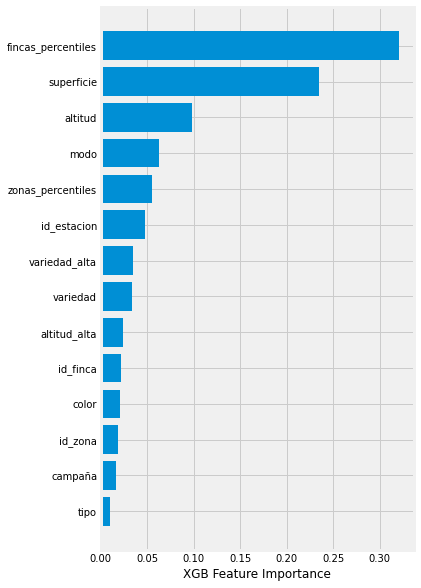

In [99]:
plt.figure(figsize=(5,10))

sorted_idx = xgb.feature_importances_.argsort()
plt.barh(y=X.columns[sorted_idx],width=xgb.feature_importances_[sorted_idx])
plt.xlabel("XGB Feature Importance")
plt.show()

### Cruzada con ETO

In [100]:
eto = pd.read_csv("C:/Users/denis/OneDrive/Escritorio/Datathon/datathon-cajamar-malbecs/data/processed/eto_processed.csv", index_col=0)
eto.head()

,ID_ESTACION,GustLocalDayAvg_1,GustLocalDayAvg_2,GustLocalDayAvg_3,GustLocalDayAvg_4,GustLocalDayAvg_5,GustLocalDayAvg_6,MSLPLocalDayAvg_1,MSLPLocalDayAvg_2,MSLPLocalDayAvg_3,MSLPLocalDayAvg_4,MSLPLocalDayAvg_5,MSLPLocalDayAvg_6,RelativeHumidityLocalDayAvg_1,RelativeHumidityLocalDayAvg_2,RelativeHumidityLocalDayAvg_3,RelativeHumidityLocalDayAvg_4,RelativeHumidityLocalDayAvg_5,RelativeHumidityLocalDayAvg_6,UVIndexLocalDayAvg_1,UVIndexLocalDayAvg_2,UVIndexLocalDayAvg_3,UVIndexLocalDayAvg_4,UVIndexLocalDayAvg_5,UVIndexLocalDayAvg_6,VisibilityLocalDayAvg_1,VisibilityLocalDayAvg_2,VisibilityLocalDayAvg_3,VisibilityLocalDayAvg_4,VisibilityLocalDayAvg_5,VisibilityLocalDayAvg_6,WindSpeedLocalDayAvg_1,WindSpeedLocalDayAvg_2,WindSpeedLocalDayAvg_3,WindSpeedLocalDayAvg_4,WindSpeedLocalDayAvg_5,WindSpeedLocalDayAvg_6,lluvia_daytime_avg_1,lluvia_daytime_avg_2,lluvia_daytime_avg_3,lluvia_daytime_avg_4,lluvia_daytime_avg_5,lluvia_daytime_avg_6,lluvia_night_avg_1,lluvia_night_avg_2,lluvia_night_avg_3,lluvia_night_avg_4,lluvia_night_avg_5,lluvia_night_avg_6,nieve_daytime_Avg_1,nieve_daytime_Avg_2,nieve_daytime_Avg_3,nieve_daytime_Avg_4,nieve_daytime_Avg_5,nieve_daytime_Avg_6,nieve_night_Avg_1,nieve_night_Avg_2,nieve_night_Avg_3,nieve_night_Avg_4,nieve_night_Avg_5,nieve_night_Avg_6,campaña
0,0,8.73,8.81,8.41,8.09,8.11,5.90,102201.83,102146.62,101755.81,101428.21,101617.30,101532.45,67.64,66.56,68.41,70.65,61.86,42.60,0.40,0.62,1.04,1.54,2.13,1.45,12703.95,12566.77,12205.02,12427.89,13459.72,16093.00,2.80,2.68,3.10,2.66,2.34,3.35,40.80,12.51,55.03,45.26,20.23,0.00,33.60,9.94,41.66,54.51,11.83,0.00,0.02,0.01,0.00,0.00,0.00,0.00,0.02,0.00,0.00,0.00,0.00,0.00,15
1,1,9.46,8.96,8.78,8.50,8.58,6.25,102234.06,102167.03,101762.08,101431.50,101629.07,101553.19,72.75,69.21,69.56,70.14,59.82,36.65,0.40,0.63,1.04,1.55,2.14,1.60,12317.72,12307.27,12143.72,12397.98,13268.26,16093.00,3.81,3.63,4.09,3.53,3.13,3.85,25.54,11.31,42.86,44.23,23.66,0.00,16.63,10.11,35.83,51.94,24.51,0.00,0.06,0.01,0.00,0.00,0.00,0.00,0.03,0.00,0.00,0.00,0.00,0.00,15
2,2,9.01,8.94,8.49,8.27,8.05,0.00,102230.35,102165.75,101763.44,101439.95,101615.43,101532.84,69.86,66.95,67.13,68.15,59.89,41.05,0.42,0.64,1.07,1.58,2.17,1.50,12708.40,12722.14,12670.05,12872.93,13692.44,16093.00,2.97,2.84,3.23,2.88,2.62,3.35,20.74,5.14,43.03,38.91,14.06,0.00,19.20,3.43,31.20,46.11,17.66,0.00,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,15
3,3,9.29,9.06,8.66,8.48,8.16,6.30,102213.03,102157.90,101758.68,101429.61,101625.83,101547.07,71.02,69.21,70.03,71.44,62.10,38.90,0.40,0.62,1.04,1.54,2.14,1.50,12500.75,12391.16,12075.28,12384.46,13293.40,16093.00,3.61,3.43,3.89,3.33,2.91,3.65,31.54,8.74,44.74,35.49,16.97,0.00,25.89,8.23,38.06,43.03,16.11,0.00,0.06,0.00,0.00,0.00,0.00,0.00,0.02,0.00,0.00,0.00,0.00,0.00,15
4,4,9.37,9.01,8.65,8.43,8.25,6.00,102229.53,102164.91,101770.68,101446.43,101620.98,101541.87,70.35,67.81,68.13,68.75,59.33,37.10,0.41,0.63,1.06,1.56,2.15,1.50,12605.38,12518.67,12333.94,12669.56,13506.27,16093.00,3.79,3.57,4.05,3.50,3.06,3.85,22.80,7.54,45.26,37.37,12.00,0.00,18.51,8.91,37.54,43.54,23.83,0.00,0.03,0.00,0.00,0.00,0.00,0.00,0.01,0.00,0.00,0.00,0.00,0.00,15


In [101]:
eto.columns = [col.lower().replace('-','_') for col in eto.columns]

In [104]:
df_join = pd.merge(df, eto, how='left', on=['id_estacion', 'campaña'])

In [108]:
for col in df_join.columns:
    df_join[col]  = df_join.groupby(['id_estacion'])[col].transform(lambda x: x.fillna(x.mean()))
    df_join[col]  = df_join[col].transform(lambda x: x.fillna(x.mean()))

In [110]:
df_models = df_join[df_join.campaña < 22]

target = 'produccion'

X = df_models.loc[:, df_models.columns != target]
y = df_models[target]

X_train = X.iloc[:len(df_models[df_models['campaña']<21]),:]
X_test = X.iloc[len(df_models[df_models['campaña']<21]):,:]
y_train = y.iloc[:len(df_models[df_models['campaña']<21])]
y_test = y.iloc[len(df_models[df_models['campaña']<21]):]

In [111]:
%%time 

#Modelo
xgb = XGBRegressor(random_state=99)

#Entrenamiento
xgb.fit(X_train, y_train)

#Predicciones
prediction = xgb.predict(X_test)

#Resultados
mse = mean_squared_error(y_test, prediction)
print(np.sqrt(mse))

8880.850886612343
Wall time: 1.63 s


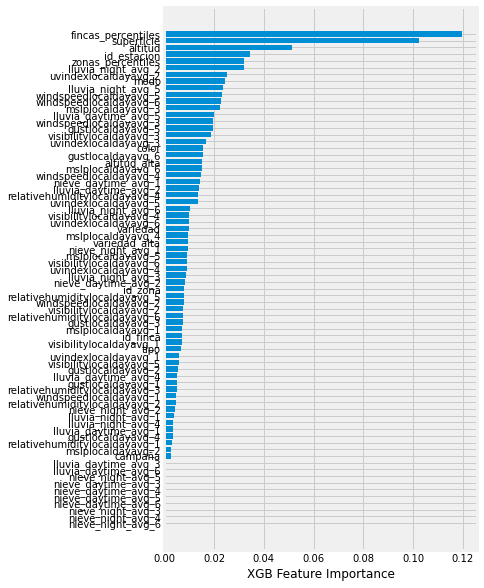

In [74]:
plt.figure(figsize=(5,10))

sorted_idx = xgb.feature_importances_.argsort()
plt.barh(y=X.columns[sorted_idx],width=xgb.feature_importances_[sorted_idx])
plt.xlabel("XGB Feature Importance")
plt.show()

### Con ETO anuales

In [112]:
gust = ['gustlocaldayavg_1', 'gustlocaldayavg_2', 'gustlocaldayavg_3',
       'gustlocaldayavg_4', 'gustlocaldayavg_5', 'gustlocaldayavg_6']

mslp = ['mslplocaldayavg_1', 'mslplocaldayavg_2', 'mslplocaldayavg_3',
       'mslplocaldayavg_4', 'mslplocaldayavg_5', 'mslplocaldayavg_6']

relative = ['relativehumiditylocaldayavg_1', 'relativehumiditylocaldayavg_2',
       'relativehumiditylocaldayavg_3', 'relativehumiditylocaldayavg_4',
       'relativehumiditylocaldayavg_5', 'relativehumiditylocaldayavg_6']

uv = ['uvindexlocaldayavg_1', 'uvindexlocaldayavg_2', 'uvindexlocaldayavg_3',
       'uvindexlocaldayavg_4', 'uvindexlocaldayavg_5', 'uvindexlocaldayavg_6']

visibility = [ 'visibilitylocaldayavg_1', 'visibilitylocaldayavg_2',
       'visibilitylocaldayavg_3', 'visibilitylocaldayavg_4',
       'visibilitylocaldayavg_5', 'visibilitylocaldayavg_6']

wind = ['windspeedlocaldayavg_1', 'windspeedlocaldayavg_2',
       'windspeedlocaldayavg_3', 'windspeedlocaldayavg_4',
       'windspeedlocaldayavg_5', 'windspeedlocaldayavg_6']

lluvia_day = ['lluvia_daytime_avg_1', 'lluvia_daytime_avg_2', 'lluvia_daytime_avg_3',
       'lluvia_daytime_avg_4', 'lluvia_daytime_avg_5', 'lluvia_daytime_avg_6']

lluvia_night = ['lluvia_night_avg_1', 'lluvia_night_avg_2', 'lluvia_night_avg_3',
       'lluvia_night_avg_4', 'lluvia_night_avg_5', 'lluvia_night_avg_6']

nieve_day = ['nieve_daytime_avg_1', 'nieve_daytime_avg_2', 'nieve_daytime_avg_3',
       'nieve_daytime_avg_4', 'nieve_daytime_avg_5', 'nieve_daytime_avg_6']

nieve_night = ['nieve_night_avg_1', 'nieve_night_avg_2', 'nieve_night_avg_3',
       'nieve_night_avg_4', 'nieve_night_avg_5', 'nieve_night_avg_6']


In [113]:
df_models2 = df_models.copy()

In [114]:
list_data = {'gust': gust, 'mslp': mslp,'relative': relative, 'uv': uv,'visibility': visibility,
              'wind': wind,'lluvia_day': lluvia_day, 'lluvia_night': lluvia_night,'nieve_day': nieve_day, 'nieve_night': nieve_night}

for name, data in list_data.items():
    df_models2[name] = df_models2[data].sum(axis=1)
    df_models2 = df_models2.drop(columns=data)

In [115]:
df_models2.head()

,campaña,id_finca,id_zona,id_estacion,variedad,modo,tipo,color,superficie,produccion,variedad_alta,altitud,altitud_alta,fincas_percentiles,zonas_percentiles,gust,mslp,relative,uv,visibility,wind,lluvia_day,lluvia_night,nieve_day,nieve_night
0,14,76953,515,4,26,2,0,1,2.64,22215.00,1,660.00,0,3.00,3,50.67,610740.25,395.23,8.06,76771.68,18.82,143.94,142.14,0.04,0.02
1,14,84318,515,4,26,2,0,1,2.64,22215.00,1,660.00,0,3.00,3,50.67,610740.25,395.23,8.06,76771.68,18.82,143.94,142.14,0.04,0.02
2,14,85579,340,4,32,2,0,1,2.91,20978.00,1,520.00,1,3.00,3,50.67,610740.25,395.23,8.06,76771.68,18.82,143.94,142.14,0.04,0.02
3,14,69671,340,4,32,2,0,1,2.91,40722.00,1,520.00,1,3.00,3,50.67,610740.25,395.23,8.06,76771.68,18.82,143.94,142.14,0.04,0.02
4,14,14001,852,14,81,1,0,1,2.82,14126.00,0,658.75,0,3.00,1,51.73,610747.46,397.00,8.08,76252.42,20.40,142.44,139.81,0.06,0.03


In [116]:
target = 'produccion'

X = df_models2.loc[:, df_models2.columns != target]
y = df_models2[target]

X_train = X.iloc[:len(df_models2[df_models2['campaña']<21]),:]
X_test = X.iloc[len(df_models2[df_models2['campaña']<21]):,:]
y_train = y.iloc[:len(df_models2[df_models2['campaña']<21])]
y_test = y.iloc[len(df_models2[df_models2['campaña']<21]):]

In [117]:
%%time 

#Modelo
xgb = XGBRegressor(random_state=99)

#Entrenamiento
xgb.fit(X_train, y_train)

#Predicciones
prediction = xgb.predict(X_test)

#Resultados
mse = mean_squared_error(y_test, prediction)
print(np.sqrt(mse))

7095.202085589397
Wall time: 1.01 s


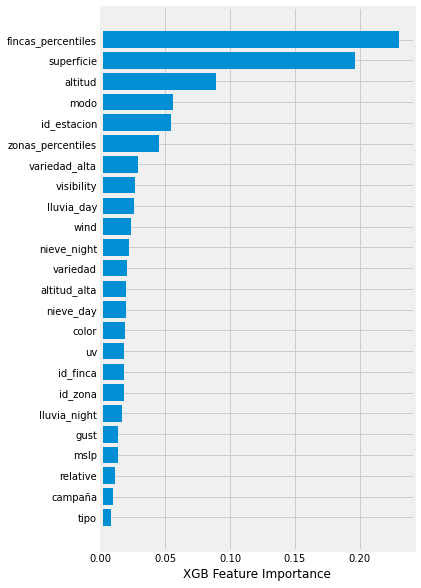

In [118]:
plt.figure(figsize=(5,10))

sorted_idx = xgb.feature_importances_.argsort()
plt.barh(y=X.columns[sorted_idx],width=xgb.feature_importances_[sorted_idx])
plt.xlabel("XGB Feature Importance")
plt.show()

## CatBoost